# Identify Fraud Accounts with Anomaly Detection: Day 7

## Environment Setup

In [17]:
# Library import
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

import tensorflow as tf

from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


## Loding Data

In [18]:
# Loding data
# df = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/training_data/final_features_day_07_no_fbtest_onlyimp_noinactive.tsv", sep="\t")

# Loding data from the GMM outputs 
df = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/gmm_outputs/gmm_clutering_outputs_day_07_k6.tsv", 
                 sep="\t")

In [ ]:
# Import the identified fraud accounts

In [121]:
df.head()

,systemid,activateexpense,activateotherincome,activatepayment,admindeactivation,adminonlinepaymentattempt,adminpayinvoiceonlineinvoice,adminpayinvoiceonlinelistview,archiveclient,archiveexpense,...,is_sales_managed,is_freshbooks_account_active,is_paying,avg_wc_description_day_7,avg_wc_notes_day_7,avg_wc_terms_day_7,avg_wc_address_day_7,invoice_count_day_7,client_count_day_7,cluster_id
0,3592461,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,2.0,6.0,0.0,0.0,1.0,2.0,1
1,3592463,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5
2,3592465,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,3592467,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,3592469,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [19]:
def changed_id(row_value):
    val = 0
    if row_value == 1:
        val = 1
    else:
        val = 0
    return val

In [20]:
# Changing the cluster id to fraud (1) and non-fraud(0)
df['new_level'] = df.apply(lambda x: changed_id(x['cluster_id']), axis=1)
df = df.drop(columns=['cluster_id'], axis=1)                  # drop the old cluster level
df = df.rename(columns={'new_level' : 'cluster_id'})          # change back to the old name of cluster id

In [21]:
df.head()

,systemid,activateexpense,activateotherincome,activatepayment,admindeactivation,adminonlinepaymentattempt,adminpayinvoiceonlineinvoice,adminpayinvoiceonlinelistview,archiveclient,archiveexpense,...,is_sales_managed,is_freshbooks_account_active,is_paying,avg_wc_description_day_7,avg_wc_notes_day_7,avg_wc_terms_day_7,avg_wc_address_day_7,invoice_count_day_7,client_count_day_7,cluster_id
0,3592461,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,2.0,6.0,0.0,0.0,1.0,2.0,1
1,3592463,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,3592465,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,3592467,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,3592469,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [22]:
# Keep a copy of the original data
df_orig = df.copy()

# Checking null in data
df.isnull().values.any()

False

In [80]:
# list(df)

## Data Standarization

In [23]:
# Normalized all features columns except the 'systemid'
column_names_to_normalize_day_7 = ['systemid', 'cluster_id']
column_names_to_normalize_day_7 = [x for x in list(df) if x not in column_names_to_not_normalize ]


# Normalized all features columns except the 'systemid'
min_max_scaler_day_7 = MinMaxScaler()
x_day_7 = df[column_names_to_normalize_day_7].values
x_scaled_day_7 = min_max_scaler_day_7.fit_transform(x_day_7)
df_temp = pd.DataFrame(x_scaled_day_7, columns=column_names_to_normalize_day_7, index = df.index)
df[column_names_to_normalize_day_7] = df_temp

# # Standard deviation based scaler
# scaler_anml = StandardScaler()
# StandardScaler(copy=True, with_mean=True, with_std=True)

# # Standarized the data 
# x = df[column_names_to_normalize].values
# x_scaled = scaler_anml.fit_transform(x)
# df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df.index)
# df[column_names_to_normalize] = df_temp

In [24]:
df.head()

,systemid,activateexpense,activateotherincome,activatepayment,admindeactivation,adminonlinepaymentattempt,adminpayinvoiceonlineinvoice,adminpayinvoiceonlinelistview,archiveclient,archiveexpense,...,is_sales_managed,is_freshbooks_account_active,is_paying,avg_wc_description_day_7,avg_wc_notes_day_7,avg_wc_terms_day_7,avg_wc_address_day_7,invoice_count_day_7,client_count_day_7,cluster_id
0,3592461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.001113,0.003446,0.0,0.0,0.000151,0.000059,1
1,3592463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0
2,3592465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0
3,3592467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0
4,3592469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0


In [83]:
# # Save the standarization model: min-max scalar
# filename_scaler_anml = '/Users/dwahid/Documents/GitHub/fraud_detection/data/saved_models/std_scaler_nn_anomaly_day_07.sav'
# pickle.dump(scaler_anml, open(filename_scaler_anml, 'wb'))

In [ ]:
# # Standarization with standard deviation:  (x-mean)/(std)
# scaler_anml_day_7 = StandardScaler()
# scaler_anml_day_7.fit(df_day_7_c1_imp_noid)
# StandardScaler(copy=True, with_mean=True, with_std=True)

# df_res = pd.DataFrame(scaler_anml_day_7.transform(df_day_7_imp_noid))


## Split Data: Training & Testing

In [31]:
# # Split data into train and test set
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.cluster_id == 0]
X_train = X_train.drop(['cluster_id'], axis=1)

y_test = X_test['cluster_id']
X_test = X_test.drop(['cluster_id'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [32]:
X_test.shape[0]

87660

In [33]:
X_train.shape[0]

336354

## Building Model
Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [34]:
input_dim = X_train.shape[1]
encoding_dim = 14


In [35]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)


Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.

In [37]:
nb_epoch = 100 # 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="/Users/dwahid/Documents/GitHub/fraud_detection/data/saved_models/nn_anomaly_model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history



Train on 336354 samples, validate on 87660 samples
Epoch 1/100
336354/336354 [==============================] - 24s 72us/step - loss: 184969129357.8011 - accuracy: 1.0000 - val_loss: 184949529074.5663 - val_accuracy: 1.0000- loss: 184974566990.8734 - ETA: 4s - loss: 184985225578.6717 - accuracy: - ETA: 4s - loss: 18497371683
Epoch 2/100
336354/336354 [==============================] - 22s 65us/step - loss: 184961478023.7610 - accuracy: 1.0000 - val_loss: 184941886738.8890 - val_accuracy: 1.0000
Epoch 3/100
336354/336354 [==============================] - 22s 65us/step - loss: 184953827830.9124 - accuracy: 1.0000 - val_loss: 184934230046.7457 - val_accuracy: 1.0000
Epoch 4/100
336354/336354 [==============================] - 23s 68us/step - loss: 184946177418.9637 - accuracy: 1.0000 - val_loss: 184926587908.4390 - val_accuracy: 1.0000
Epoch 5/100
336354/336354 [==============================] - 22s 66us/step - loss: 184938526793.1755 - accuracy: 1.0000 - val_loss: 184918931798.6884 - va

336354/336354 [==============================] - 29s 85us/step - loss: 184623752186.8793 - accuracy: 1.0000 - val_loss: 184604146598.0525 - val_accuracy: 1.000084621676994.7199 - accuracy: 1 - ETA: 3s - loss: 184625682504.0538 - ac
Epoch 47/100
336354/336354 [==============================] - 29s 86us/step - loss: 184616054078.8899 - accuracy: 1.0000 - val_loss: 184596451619.7570 - val_accuracy: 1.0000
Epoch 48/100
336354/336354 [==============================] - 30s 91us/step - loss: 184608365086.5994 - accuracy: 1.0000 - val_loss: 184588816550.9052 - val_accuracy: 1.0000s: 184606153649.0135 - acc - ETA: 
Epoch 49/100
336354/336354 [==============================] - 25s 75us/step - loss: 184600837296.6307 - accuracy: 1.0000 - val_loss: 184581349078.0751 - val_accuracy: 1.0000s: 184598133425.1729 - accur - ETA: 0s - loss: 184591522255.8230 - accura
Epoch 50/100
336354/336354 [==============================] - 19s 56us/step - loss: 184593371494.9727 - accuracy: 1.0000 - val_loss: 184573

336354/336354 [==============================] - 29s 87us/step - loss: 184287398717.8213 - accuracy: 1.0000 - val_loss: 184267927962.2542 - val_accuracy: 1.0000
Epoch 92/100
336354/336354 [==============================] - 29s 85us/step - loss: 184279938553.4393 - accuracy: 1.0000 - val_loss: 184260466974.9910 - val_accuracy: 1.0000
Epoch 93/100
336354/336354 [==============================] - 31s 92us/step - loss: 184272480539.3373 - accuracy: 1.0000 - val_loss: 184253004438.6679 - val_accuracy: 1.0000
Epoch 94/100
336354/336354 [==============================] - 30s 89us/step - loss: 184265021459.2529 - accuracy: 1.0000 - val_loss: 184245543553.0805 - val_accuracy: 1.0000
Epoch 95/100
336354/336354 [==============================] - 29s 86us/step - loss: 184257562143.3118 - accuracy: 1.0000 - val_loss: 184238097418.7003 - val_accuracy: 1.0000431 - accuracy: 1.000 - ETA: 5s - loss: 184300617764.2300 - accura - ETA: 5s - loss: 184291292056.4109 - accuracy: 1.0 - ETA: 5s 
Epoch 96/100
3

In [113]:
autoencoder = load_model('/Users/dwahid/Documents/GitHub/fraud_detection/data/saved_models/nn_anomaly_model.h5')


## Evaluation

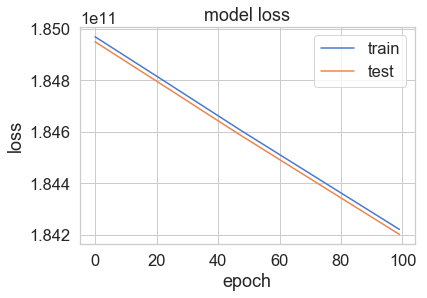

In [38]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');


The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [115]:
predictions = autoencoder.predict(X_test)


In [116]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})


In [117]:
error_df.describe()


,reconstruction_error,true_class
count,8.766000e+04,87660.000000
mean,1.849633e+11,0.040771
std,2.391252e+10,0.197761
min,1.450105e+11,0.000000
25%,1.640163e+11,0.000000
50%,1.842189e+11,0.000000
75%,2.055450e+11,0.000000
max,2.277494e+11,1.000000


In [118]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

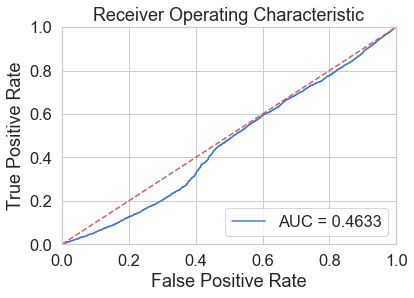

In [119]:

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();